<a href="https://colab.research.google.com/github/feliciahf/data_science_exam/blob/main/Hippocorpus_LSTM_ipynb_sigmoid_dropout(0_5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [1]:
#Import the relevant packages
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import keras
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Import data

In [2]:
# import csv file as dataframe (from GitHub repo)
url = 'https://raw.githubusercontent.com/feliciahf/data_science_exam/main/hippoCorpusV2.csv'
df = pd.read_csv(url, encoding='latin1')

In [3]:
# remove columns with uninformative information (AssignmentId, WorkerId, recAgnPairId, recImgPairId)
uninformative_cols = ["AssignmentId", "WorkerId", "recAgnPairId", "recImgPairId"]
df = df.drop(columns=uninformative_cols)

In [4]:
# drop the retold column
df = df[df.memType != 'retold']

In [5]:
# make labels column using numerical values
df.memType = pd.Categorical(df.memType)
df['label'] = df.memType.cat.codes

In [6]:
# story type corresponding to label
print(f"Label 0: {df.loc[df['label'] == 0,'memType'].unique()}")
print(f"Label 1: {df.loc[df['label'] == 1,'memType'].unique()}")

Label 0: ['imagined']
Categories (1, object): ['imagined']
Label 1: ['recalled']
Categories (1, object): ['recalled']


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5535 entries, 0 to 6853
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   WorkTimeInSeconds  5535 non-null   int64   
 1   annotatorAge       5518 non-null   float64 
 2   annotatorGender    5535 non-null   object  
 3   annotatorRace      5535 non-null   object  
 4   distracted         5535 non-null   float64 
 5   draining           5535 non-null   float64 
 6   frequency          2779 non-null   float64 
 7   importance         5391 non-null   float64 
 8   logTimeSinceEvent  5535 non-null   float64 
 9   mainEvent          5535 non-null   object  
 10  memType            5535 non-null   category
 11  mostSurprising     5535 non-null   object  
 12  openness           5535 non-null   float64 
 13  similarity         2756 non-null   float64 
 14  similarityReason   2756 non-null   object  
 15  story              5535 non-null   object  
 16  stress

In [8]:
#MARTINE - Gets the number of stories in the two categories; recalled and imagined??
df.memType.value_counts()

recalled    2779
imagined    2756
Name: memType, dtype: int64

In [9]:
def print_plot(index):
    example = df[df.index == index][['story', 'memType']].values[0]
    if len(example) > 0:
        print(example[0])
        print('memType:', example[1])
print_plot(10)

About a month ago me and my girlfriend went to the zoo. It was an unexpected trip we just decided to go on a random Wednesday. It was a pretty hot day that day considering it was the middle of July. As soon as we got in, we saw that there were some seals to the left of the entrance so we saw them for a few minutes. Then we went to the insect section of the zoo. There were so many of them like spiders, scorpions, also bigger animals like cobras, rattlesnakes stuff like that. Then we saw the elephants. It was pretty interesting because they were in an area that looked like a jungle and off in the distance we heard gorillas grunting. So we walked around until we found the gorillas and around there we also saw other kinds of primates like chimpanzees. We walked around a bit more and we stumbled upon all the other African animals like tigers, lions, giraffes etc. It was actually pretty cool to see the giraffes because one of them got really close to me. Along the way we saw a lot of differe

# Preprocessing

In [10]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['story'] = df['story'].apply(clean_text)
df['story'] = df['story'].str.replace('\d+', '')

In [11]:
df['story']

0       concerts favorite thing boyfriend knew thats a...
1       day started perfectly great drive denver show ...
2       seems like yesterday today makes five months a...
3       five months ago niece nephew born sisters firs...
4       month ago went burning man hard time life felt...
                              ...                        
5530    dog diagnosed lymphoma year ago chemotherapy r...
5531    vacation job went casper took side job lasted ...
5532    event birthday party nephew turned five gather...
5533    event occurred two weeks ago going shopping bi...
5534    past year involved court situation involving d...
Name: story, Length: 5535, dtype: object

In [12]:
print_plot(10)

vacation visit southeast asia every years least small tourist town thailand right pattaya beach fairly late one evening decided roam around city take pictures citizens shops nightclubs etc found rather secluded dingy part city wasnt sure eactly get back hotel looking one motorbike tais didnt see looking around group thais probably early s could tell part gang something like thought sure going get robbed beat across small street giving eye sudden tai went waved frantically saw drove pick got back hotel safely pretty shaken knew things going go badly small gang caught city another two weeks still ventured tried lot careful parts ventured really known better quite countries cities safe even though im somewhat used types environments still scary tourists known disappear never show happens fairly often especially countries completely corrupt police force still travel im little careful city go go particular city
memType: imagined


In [13]:
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each story
MAX_SEQUENCE_LENGTH = 1967
# This is fixed
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['story'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 24496 unique tokens.


In [14]:
X = tokenizer.texts_to_sequences(df['story'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5535, 1967)


In [15]:
# change categorical strings to values
Y = pd.get_dummies(df['memType']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5535, 2)


# Split dataset

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4428, 1967) (4428, 2)
(1107, 1967) (1107, 2)


# LSTM Model

In [26]:
import keras

#Groups the layers into a linear stack
model = keras.Sequential()


model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.8))

model.add(keras.layers.LSTM(25, dropout=0.5, recurrent_dropout=0.2, return_sequences=True))
model.add(keras.layers.LSTM(25, dropout=0.5, recurrent_dropout=0.2, return_sequences= True))
model.add(keras.layers.LSTM(25, dropout=0.5, recurrent_dropout=0.2))
model.add(keras.layers.Dense(2, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 3
batch_size = 32

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
111/111 [==============================] - 711s 6s/step - loss: 0.6934 - accuracy: 0.5025 - val_loss: 0.6923 - val_accuracy: 0.5384
Epoch 2/3
111/111 [==============================] - 701s 6s/step - loss: 0.6875 - accuracy: 0.5445 - val_loss: 0.6552 - val_accuracy: 0.6219
Epoch 3/3
111/111 [==============================] - 701s 6s/step - loss: 0.6178 - accuracy: 0.6714 - val_loss: 0.6365 - val_accuracy: 0.6309


# Model evaluation

In [27]:
# model evaluation
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

35/35 [==============================] - 18s 518ms/step - loss: 0.6608 - accuracy: 0.6134
Test set
  Loss: 0.661
  Accuracy: 0.613


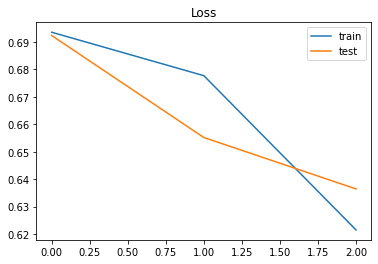

In [28]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

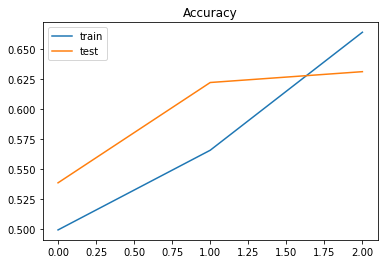

In [29]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();